<div align = 'center'>
    <img src="../images/ga_logo_large.png">
</div>

---
## **Natural Language Processing: Reddit Post Classification**

----
### **Pre Processing and Model Training**

In [690]:
# import libraries needed for this notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# metrics
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             RocCurveDisplay)

In [288]:
# read in clean file
file_path = '../data/clean_data/reddit2.csv'

reddit = pd.read_csv(file_path)

# check dimensions and a couple rows
print(reddit.shape)
reddit.tail(2)

(2761, 10)


,post_title,post_text,post_title_length,post_title_wc,post_text_length,post_text_wc,topic,title_nouns,text_nouns,all_nouns
2759,House before jobs?,Husband and I are looking to move back to my h...,18,3,734,141,0,"['house', 'job']","['husband', 'i', 'hometown', 'home', '%', 'mar...",house job husband i hometown home % market are...
2760,Home buying question,My fiancé and I are getting married in May and...,20,3,550,112,0,"['home', 'buying', 'question']","['fiancé', 'i', 'apartment', 'year', 'forever'...",home buying question fiancé i apartment year f...


This dataset is already clean, there are no missing values or duplicates.  Let's proceed to pre-processing.

---
**Pre-Processing Stage**<br>
Set up _**X**_ matrix and **y** target vector

From the EDA stage, it was determined that the classifier we're about to build will rely on data from the `post_title` column.  The target will be the `topic` column, where a value of `0` means the row contains a real estate post, and a value of `1` means the row contains a travel post.  The aim of the classifier is to predict whether any given post is a travel post or not.

In [290]:
# set up matrix and target
X = reddit['post_title']
y = reddit['topic']

# confirm shapes
X.shape, y.shape

((2761,), (2761,))

**Calculate Baseline Accuracy**

In [292]:
y.value_counts(normalize = True)

topic
1    0.517204
0    0.482796
Name: proportion, dtype: float64

In [294]:
base_acc = y.value_counts(normalize = True)[1]

In [296]:
print(f"The classes are very well balanced in this dataset. Travel posts account for {round(base_acc, 3)*100}% of the data.\n"
"The various models that will be attempted need to beat this level of accuracy.")

The classes are very well balanced in this dataset. Travel posts account for 51.7% of the data.
The various models that will be attempted need to beat this level of accuracy.


**Training and Testing Set Splits**

In [298]:
# use 70/30 split
# although classes are almost evenly balanced, I will still stratify the data to keep the same ratio
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.7,
                                                    stratify = y,
                                                    random_state = 1976)

In [300]:
# confirm stratification
print(y_train.value_counts(normalize = True))
print('*'*35)
print(y_test.value_counts(normalize = True))

topic
1    0.517081
0    0.482919
Name: proportion, dtype: float64
***********************************
topic
1    0.517491
0    0.482509
Name: proportion, dtype: float64


Both the training set and the testing set are set up and balanced correctly to mimic the original data.

---
**Model Buildup, Training and Evaluation Stage**

Use function below to quickly evaluate models.

In [302]:
def evaluate_model(model,
                   X_train = X_train,
                   X_test = X_test,
                   y_train = y_train,
                   y_test = y_test):

    # calculate metrics for current model design/iteration------------------------
    preds = model.predict(X_test)
    
    acc = round(model.score(X_train, y_train), 3)     # training score
    acc1 = round(model.best_score_, 3)                # best accuracy score
    acc2 = round(model.score(X_test, y_test), 3)      # actual accuracy score on test set
    mis = round(1 - acc2, 3)                          # misclassification rate on test set
    prec = round(precision_score(y_test, preds), 3)   # precision score
    f1 = round(f1_score(y_test, preds), 3)            # f1 score
    # ----------------------------------------------------------------------------
    
    # plot confusion matrix and ROC curve-----------------------------------------
    
    # container
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))

    # source to tweak with the confusion matrix parameters: 
    # https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                          display_labels = ['Real Estate', 'Travel'],
                                          ax = axes[0], colorbar = False,
                                          cmap = 'Blues')


    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=axes[1],
                                   color = '#00bcd4');

    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)


    plt.legend(frameon = False, loc = 'lower right')

    # source for this line: 
    # https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots
    plt.subplots_adjust(wspace=0.4)
    #---------------------------------------------------------------------------------
    
    
    # print statements----------------------------------------------------------------
    print(f'Training Score: {acc}')
    print(f'Best Accuracy Score: {acc1}')
    print(f'Actual Accuracy Score: {acc2}')
    print(f'Misclassification Rate: {mis}')
    print(f'Precision Score: {prec}')
    print(f'F1 Score: {f1}')
    #---------------------------------------------------------------------------------
    
    
    return {'train_accuracy': acc,
            'best_accuracy': acc1, 
            'test_accuracy': acc2,
            'misclassification': mis,
            'precision': prec,
            'f1_score': f1
           }    

The list below (`metrics`) will store the metrics returned from the `evaluate_model()` function.<br>
The second list at the bottom (`models`), will store the name of the models to append to dataframe at the end.

In [304]:
metrics = []
models = []

---
**Model 1**

In [306]:
# use Logistic Regression with Count Vectorizer
# build pipeline
pipe1 = Pipeline([
    ('cvec1', CountVectorizer()),
    ('model1', LogisticRegression())
])

In [320]:
# grid search parameters
params1 = {'cvec1__stop_words': [None, 'english'],
           'cvec1__max_features': [None, 1000, 5000, 10000],
           'model1__penalty': [None, 'l2'],
           'model1__random_state': [1029]
          }

In [322]:
# grid search setup
gs1 = GridSearchCV(
    pipe1,
    param_grid = params1,
    n_jobs = -1,
    verbose = 1
)

In [324]:
# fit model
gs1.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=Pipeline(steps=[('cvec1', CountVectorizer()),
                                       ('model1', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec1__max_features': [None, 1000, 5000, 10000],
                         'cvec1__stop_words': [None, 'english'],
                         'model1__penalty': [None, 'l2'],
                         'model1__random_state': [1029]},
             verbose=1)

**Model 1 Evaluation**

In [326]:
# best params
gs1.best_params_

{'cvec1__max_features': None,
 'cvec1__stop_words': None,
 'model1__penalty': None,
 'model1__random_state': 1029}

In [1054]:
# append model details
models.append(['gs1','LogReg and CountVectorizer'])

Training Score: 1.0
Best Accuracy Score: 0.93
Actual Accuracy Score: 0.931
Misclassification Rate: 0.069
Precision Score: 0.941
F1 Score: 0.933


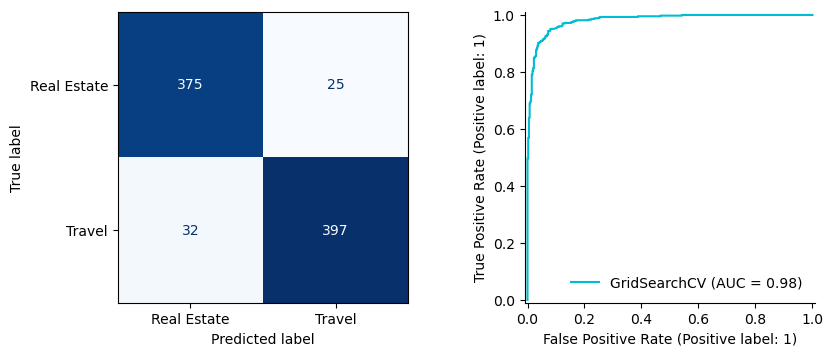

In [1056]:
metrics.append(evaluate_model(gs1))
plt.savefig('../images/01_model_gs1.png')

---
**Model 2**

In [332]:
# use Logistic Regression again, this time with TfidfVectorizer
# pipeline
pipe2 = Pipeline([
    ('tvec1', TfidfVectorizer()),
    ('model2', LogisticRegression())
])

In [334]:
# grid search parameters
params2 = {
    'tvec1__stop_words': [None, 'english'],
    'tvec1__ngram_range':[(1, 1), (1, 2)],
    'tvec1__max_features': [None, 1000, 5000, 10000],
    'model2__penalty': [None, 'l2'],
    'model2__random_state': [1029]
}

In [336]:
# grid search setup
gs2 = GridSearchCV(
    pipe2,
    param_grid = params2,
    n_jobs = -1,
    verbose = 1
)

In [338]:
# fit model
gs2.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(estimator=Pipeline(steps=[('tvec1', TfidfVectorizer()),
                                       ('model2', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model2__penalty': [None, 'l2'],
                         'model2__random_state': [1029],
                         'tvec1__max_features': [None, 1000, 5000, 10000],
                         'tvec1__ngram_range': [(1, 1), (1, 2)],
                         'tvec1__stop_words': [None, 'english']},
             verbose=1)

**Model 2 Evaluation**

In [340]:
# best parameters
gs2.best_params_

{'model2__penalty': None,
 'model2__random_state': 1029,
 'tvec1__max_features': None,
 'tvec1__ngram_range': (1, 1),
 'tvec1__stop_words': 'english'}

In [1058]:
# append model details
models.append(['gs2','LogReg and TfidfVectorizer'])

Training Score: 1.0
Best Accuracy Score: 0.938
Actual Accuracy Score: 0.935
Misclassification Rate: 0.065
Precision Score: 0.958
F1 Score: 0.936


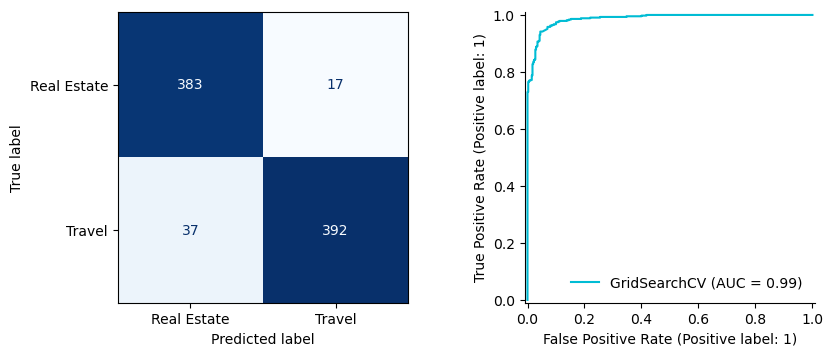

In [1060]:
metrics.append(evaluate_model(gs2))
plt.savefig('../images/02_model_gs2.png')

---
**Model 3**

In [354]:
# use KNeighborsClassifier with CountVectorizer
# pipeline
pipe3 = Pipeline([
    ('cvec2', CountVectorizer()),
    ('model3', KNeighborsClassifier())
])

In [362]:
# grid search params
params3 = {
    'cvec2__stop_words': [None, 'english'],
    'cvec2__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'cvec2__max_features': [None, 1000, 5000, 10000],
    'model3__n_neighbors': [3, 5, 7, 9, 11],
    'model3__weights': ['uniform', 'distance']
}

In [364]:
# grid search setup
gs3 = GridSearchCV(
    pipe3,
    param_grid = params3,
    n_jobs = -1,
    verbose = 1
)

In [366]:
# fit model
gs3.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(estimator=Pipeline(steps=[('cvec2', CountVectorizer()),
                                       ('model3', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'cvec2__max_features': [None, 1000, 5000, 10000],
                         'cvec2__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec2__stop_words': [None, 'english'],
                         'model3__n_neighbors': [3, 5, 7, 9, 11],
                         'model3__weights': ['uniform', 'distance']},
             verbose=1)

**Model 3 Evaluaton**

In [368]:
# best params
gs3.best_params_

{'cvec2__max_features': 1000,
 'cvec2__ngram_range': (1, 2),
 'cvec2__stop_words': 'english',
 'model3__n_neighbors': 3,
 'model3__weights': 'uniform'}

In [1062]:
# append model details
models.append(['gs3', 'KNClass and CountVectorizer'])

Training Score: 0.957
Best Accuracy Score: 0.783
Actual Accuracy Score: 0.785
Misclassification Rate: 0.215
Precision Score: 0.947
F1 Score: 0.749


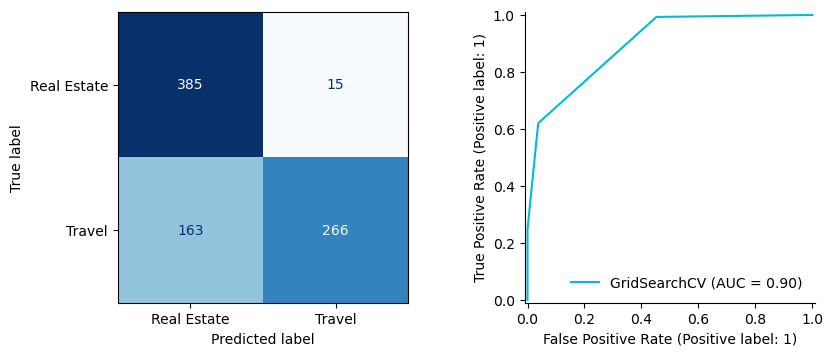

In [1064]:
metrics.append(evaluate_model(gs3))
plt.savefig('../images/03_model_gs3.png')

---
**Model 4**

In [374]:
# k neighbor classifier with TfidfVectorizer
# pipeline setup
pipe4 = Pipeline([
    ('tvec2', TfidfVectorizer()),
    ('model4', KNeighborsClassifier())
])

In [376]:
# grid params
params4 = {
    'tvec2__stop_words': [None, 'english'],
    'tvec2__ngram_range':[(1, 1), (1, 2), (2, 2)],
    'tvec2__max_features': [None, 1000, 5000, 10000],
    'model4__n_neighbors': [*range(3, 22, 2)],
    'model4__weights': ['uniform', 'distance'],
    'model4__p': [1, 2]
}

In [378]:
# grid setup
gs4 = GridSearchCV(
    pipe4,
    param_grid = params4,
    cv = 7,
    n_jobs = -1,
    verbose = 1    
)

In [380]:
# fit model
gs4.fit(X_train, y_train)

Fitting 7 folds for each of 960 candidates, totalling 6720 fits


GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('tvec2', TfidfVectorizer()),
                                       ('model4', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'model4__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19,
                                                 21],
                         'model4__p': [1, 2],
                         'model4__weights': ['uniform', 'distance'],
                         'tvec2__max_features': [None, 1000, 5000, 10000],
                         'tvec2__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec2__stop_words': [None, 'english']},
             verbose=1)

**Model 4 Evaluation**

In [382]:
# best params
gs4.best_params_

{'model4__n_neighbors': 21,
 'model4__p': 2,
 'model4__weights': 'distance',
 'tvec2__max_features': None,
 'tvec2__ngram_range': (1, 1),
 'tvec2__stop_words': None}

In [1066]:
# append model details
models.append(['gs4', 'KNClass and TfidfVectorizer'])

Training Score: 1.0
Best Accuracy Score: 0.904
Actual Accuracy Score: 0.912
Misclassification Rate: 0.088
Precision Score: 0.936
F1 Score: 0.913


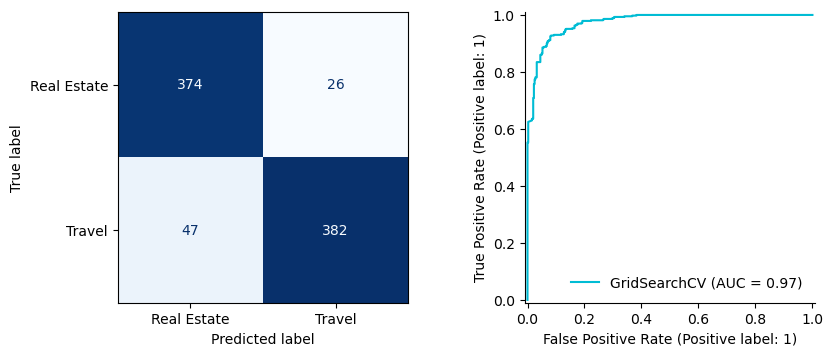

In [1068]:
# metrics summary
metrics.append(evaluate_model(gs4))
plt.savefig('../images/04_model_gs4.png')

----
**Model 5**

In [388]:
# random forest class with tfidfvectorizer
# pipeline setup
pipe5 = Pipeline([
    ('tvec3', TfidfVectorizer()),
    ('model5', RandomForestClassifier())
])

In [390]:
# grid params
params5 = {
    'tvec3__stop_words': [None, 'english'],
    'model5__n_estimators': [*range(100, 500, 100)],
    'model5__max_depth': [*range(1, 50, 2)],
    'model5__random_state': [29]
}

In [392]:
# grid setup
gs5 = GridSearchCV(
    pipe5,
    param_grid = params5,
    n_jobs = -1,
    verbose = 1
)

In [394]:
# fit model
gs5.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(estimator=Pipeline(steps=[('tvec3', TfidfVectorizer()),
                                       ('model5', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'model5__max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17,
                                               19, 21, 23, 25, 27, 29, 31, 33,
                                               35, 37, 39, 41, 43, 45, 47, 49],
                         'model5__n_estimators': [100, 200, 300, 400],
                         'model5__random_state': [29],
                         'tvec3__stop_words': [None, 'english']},
             verbose=1)

**Model 5 Evaluation**

In [396]:
# best parameters
gs5.best_params_

{'model5__max_depth': 49,
 'model5__n_estimators': 400,
 'model5__random_state': 29,
 'tvec3__stop_words': None}

In [1070]:
# append model details
models.append(['gs5', 'RndmForest and TfidfVectorizer'])

Training Score: 0.947
Best Accuracy Score: 0.866
Actual Accuracy Score: 0.865
Misclassification Rate: 0.135
Precision Score: 0.818
F1 Score: 0.879


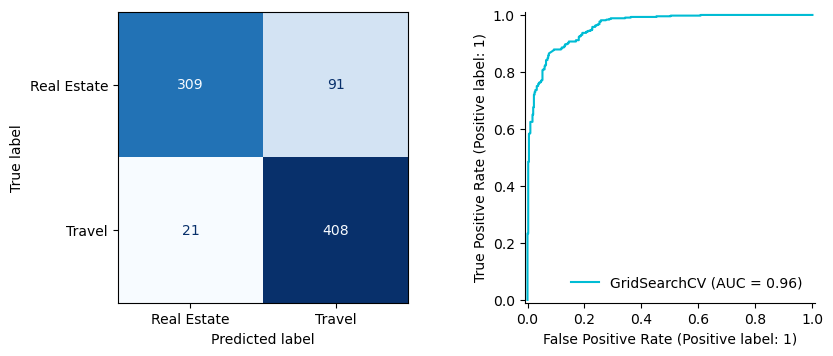

In [1072]:
# metrics summary
metrics.append(evaluate_model(gs5))
plt.savefig('../images/05_model_gs5.png')

---
**Model 6**

In [402]:
# random forest class with tfidfvectorizer, part 2
# pipeline setup
pipe6 = Pipeline([
    ('tvec4', TfidfVectorizer()),
    ('model6', RandomForestClassifier())
])

In [404]:
# grid params
params6 = {
    'tvec4__stop_words': [None, 'english'],
    'tvec4__ngram_range':[(1, 1), (1, 2), (2, 2)],
    'tvec4__max_features': [None, 10000],
    'model6__n_estimators': [*range(100, 200, 20)],
    'model6__max_depth': [*range(1, 100, 5)],
    'model6__random_state': [29]
}

In [406]:
# grid setup
gs6 = GridSearchCV(
    pipe6,
    param_grid = params6,
    n_jobs = -1,
    verbose = 1
)

In [408]:
# fit model, set timer, do something else...
gs6.fit(X_train, y_train)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


C:\Users\fuego\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=Pipeline(steps=[('tvec4', TfidfVectorizer()),
                                       ('model6', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'model6__max_depth': [1, 6, 11, 16, 21, 26, 31, 36, 41,
                                               46, 51, 56, 61, 66, 71, 76, 81,
                                               86, 91, 96],
                         'model6__n_estimators': [100, 120, 140, 160, 180],
                         'model6__random_state': [29],
                         'tvec4__max_features': [None, 10000],
                         'tvec4__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec4__stop_words': [None, 'english']},
             verbose=1)

**Model 6 Evaluation**

In [410]:
# best params
gs6.best_params_

{'model6__max_depth': 91,
 'model6__n_estimators': 100,
 'model6__random_state': 29,
 'tvec4__max_features': None,
 'tvec4__ngram_range': (1, 1),
 'tvec4__stop_words': None}

In [1074]:
# append model details
models.append(['gs6', 'RndmForest and TfidfVectorizer'])

Training Score: 0.976
Best Accuracy Score: 0.873
Actual Accuracy Score: 0.859
Misclassification Rate: 0.141
Precision Score: 0.82
F1 Score: 0.872


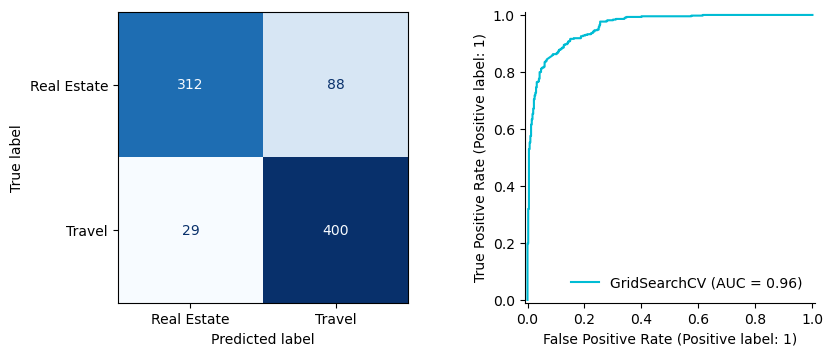

In [1076]:
# metrics summary
metrics.append(evaluate_model(gs6))
plt.savefig('../images/06_model_gs6.png')

---
**Evaluation Observations**

Every single model exceeded the baseline accuracy, which was calculated at 51.5%.<br><br>
The worst performing model was the `KNeighborsClassifier` when coupled with the transformer `CountVectorizer`, its accuracy rate was 77.8%.  The key focus, though, was classification rate, so that same model missclassified travel posts a staregging 22.2% of the time!<br><br>
Interestingly, `KNeighborsClassifier` performed better when paired with the `TfidfVectorizer` transformer. That being said, on this specific iteration, the tuning of the hyperparameters allowed for a wider range of _**k**_ values to try on.<br><br>
The best performing model was `LogisticRegression` when paired with `TfidfVectorizer`.  This model achieved the lowest misclassfication rate at 5.7%, which is still relatively high given the fact that travel and real estate are very distinct topics. The most interesting insight for this model, as far as the hyperparameters were concerned, was that it was given the choice to also tokenize the text based on bi-grams by passing the option to the `ngram_range` parameter.  Based on the returned best parameters, that's exactly what it did, it did better with the bi-grams.<br><br>
The `RandomForestClassifier` models didn't do so well when graded by misclassification rate (over 13% in both iterattions).  More fine tuning of the hyper parameters may be needed, but the grid searches for these classifiers consume a lot of time, so this is recommended for a future iteration of this project.

---
**Metrics Summary**

In [1078]:
# build DF to serve as metrics summary table
summary = pd.DataFrame(models, columns = ['id', 'model_details'])
summary = pd.concat([summary, pd.DataFrame(metrics)], axis = 1)
summary

,id,model_details,train_accuracy,best_accuracy,test_accuracy,misclassification,precision,f1_score
0,gs1,LogReg and CountVectorizer,1.000,0.930,0.931,0.069,0.941,0.933
1,gs2,LogReg and TfidfVectorizer,1.000,0.938,0.935,0.065,0.958,0.936
2,gs3,KNClass and CountVectorizer,0.957,0.783,0.785,0.215,0.947,0.749
3,gs4,KNClass and TfidfVectorizer,1.000,0.904,0.912,0.088,0.936,0.913
4,gs5,RndmForest and TfidfVectorizer,0.947,0.866,0.865,0.135,0.818,0.879
5,gs6,RndmForest and TfidfVectorizer,0.976,0.873,0.859,0.141,0.820,0.872


The table above is a brief summary of key metrics for each one of the evaluated models.

---------
### **Updates Made Post Submission**

In [418]:
X1 = reddit['all_nouns']
y1 = reddit['topic']

X1.shape, y1.shape

((2761,), (2761,))

In [420]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1,
                                                        train_size = 0.7,
                                                        stratify = y1,
                                                        random_state = 1976)

---
**Model 7**

In [508]:
pipe7 = Pipeline([
    ('tvec5', TfidfVectorizer()),
    ('model7', LogisticRegression())
])

In [510]:
params7 = {
    'tvec5__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)],
    'tvec5__max_features': [None, 500, 1000, 5000, 10000],
    'model7__penalty': [None, 'l2'],
    'model7__random_state': [1029]
}

In [512]:
gs7 = GridSearchCV(
    pipe7,
    param_grid = params7,
    n_jobs = -1,
    verbose = 1
)

In [514]:
gs7.fit(X_train1, y_train1)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=Pipeline(steps=[('tvec5', TfidfVectorizer()),
                                       ('model7', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model7__penalty': [None, 'l2'],
                         'model7__random_state': [1029],
                         'tvec5__max_features': [None, 500, 1000, 5000, 10000],
                         'tvec5__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2),
                                                (2, 3), (3, 3)]},
             verbose=1)

In [516]:
gs7.best_params_

{'model7__penalty': None,
 'model7__random_state': 1029,
 'tvec5__max_features': 5000,
 'tvec5__ngram_range': (1, 2)}

In [1080]:
# append model details
models.append(['gs7', 'LogReg and TfidfVectorizer'])

Training Score: 0.999
Best Accuracy Score: 0.99
Actual Accuracy Score: 0.984
Misclassification Rate: 0.016
Precision Score: 0.981
F1 Score: 0.985


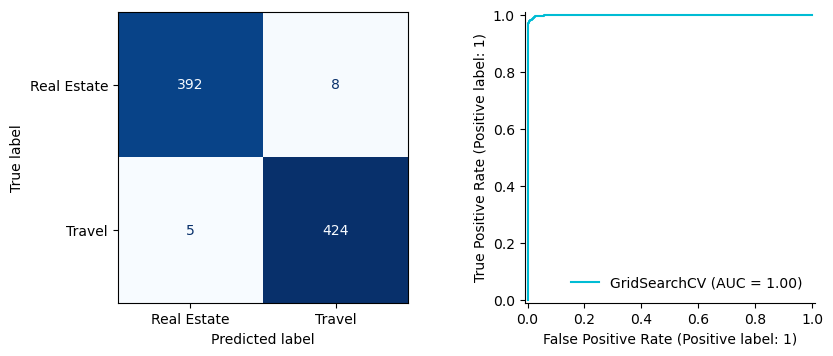

In [1082]:
metrics.append(evaluate_model(gs7,
                              X_train = X_train1,
                              X_test = X_test1,
                              y_train = y_train1,
                              y_test = y_test1
                             ))

---
**Model 8**

In [461]:
pipe8 = Pipeline([
    ('tvec6', TfidfVectorizer()),
    ('model8', LogisticRegression())
])

In [465]:
params8 = {
    'tvec6__min_df': [1, 2, 5],
    'tvec6__max_df': [0.75, 0.85, 0.9],
    'tvec6__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)],
    'tvec6__max_features': [None, 500, 1000, 5000],
    'model8__C': [0.01, 0.1, 1, 10],
    'model8__penalty': [None, 'l2'],
    'model8__class_weight': [None, 'balanced'],
    'model8__random_state': [1029]
}

In [467]:
gs8 = GridSearchCV(
    pipe8,
    param_grid = params8,
    n_jobs = -1,
    verbose = 1
)

In [469]:
gs8.fit(X_train1, y_train1)

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


C:\Users\fuego\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('tvec6', TfidfVectorizer()),
                                       ('model8', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model8__C': [0.01, 0.1, 1, 10],
                         'model8__class_weight': [None, 'balanced'],
                         'model8__penalty': [None, 'l2'],
                         'model8__random_state': [1029],
                         'tvec6__max_df': [0.75, 0.85, 0.9],
                         'tvec6__max_features': [None, 500, 1000, 5000],
                         'tvec6__min_df': [1, 2, 5],
                         'tvec6__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2),
                                                (2, 3), (3, 3)]},
             verbose=1)

In [471]:
gs8.best_params_

{'model8__C': 0.01,
 'model8__class_weight': None,
 'model8__penalty': None,
 'model8__random_state': 1029,
 'tvec6__max_df': 0.75,
 'tvec6__max_features': 5000,
 'tvec6__min_df': 1,
 'tvec6__ngram_range': (1, 2)}

In [1084]:
# append model details
models.append(['gs8', 'LogReg and TfidfVectorizer'])

Training Score: 0.999
Best Accuracy Score: 0.99
Actual Accuracy Score: 0.984
Misclassification Rate: 0.016
Precision Score: 0.981
F1 Score: 0.985


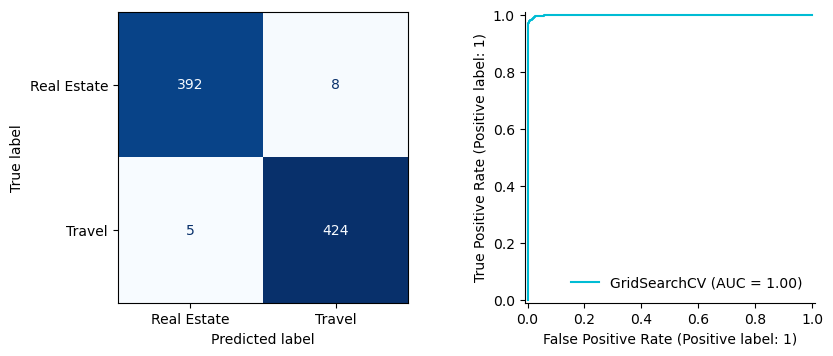

In [1086]:
metrics.append(evaluate_model(gs8,
                              X_train = X_train1,
                              X_test = X_test1,
                              y_train = y_train1,
                              y_test = y_test1
                             ))

---
**Model 9**

In [518]:
pipe9 = Pipeline([
    ('tvec7', TfidfVectorizer()),
    ('model9', LogisticRegression())
])

In [581]:
params9 = {
    'tvec7__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)],
    'tvec7__max_features': [None, 500, 1000, 5000, 10000],
    'model9__penalty': [None, 'l2'],
    'model9__random_state': [1029]
}

In [583]:
# grid search
gs9 = GridSearchCV(
    pipe9,
    param_grid = params9,
    n_jobs = -1,
    verbose = 1
)

In [931]:
gs9.fit(X_train1, y_train1)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=Pipeline(steps=[('tvec7', TfidfVectorizer()),
                                       ('model9', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model9__penalty': [None, 'l2'],
                         'model9__random_state': [1029],
                         'tvec7__max_features': [None, 500, 1000, 5000, 10000],
                         'tvec7__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2),
                                                (2, 3), (3, 3)]},
             verbose=1)

In [933]:
gs9.best_params_

{'model9__penalty': None,
 'model9__random_state': 1029,
 'tvec7__max_features': 5000,
 'tvec7__ngram_range': (1, 2)}

In [1088]:
models.append(['gs9', 'LogReg and TfidfVectorizer'])

Training Score: 0.999
Best Accuracy Score: 0.99
Actual Accuracy Score: 0.984
Misclassification Rate: 0.016
Precision Score: 0.981
F1 Score: 0.985


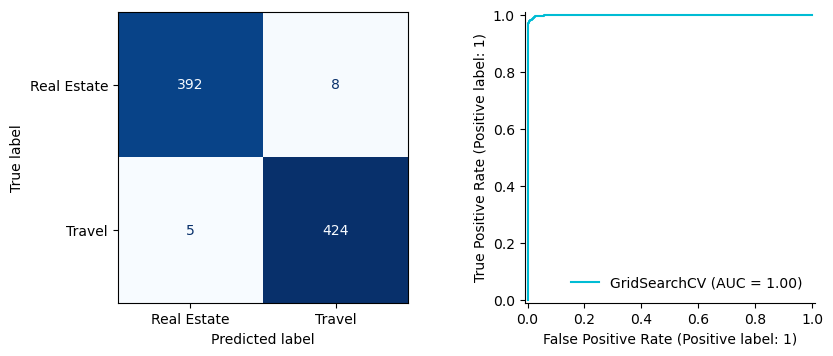

In [1090]:
metrics.append(evaluate_model(gs9,
                              X_train = X_train1,
                              X_test = X_test1,
                              y_train = y_train1,
                              y_test = y_test1
                             ))

---
**Model 10**

In [533]:
pipe10 = Pipeline([
    ('tvec8', TfidfVectorizer()),
    ('model10', LogisticRegression())
])

In [535]:
params10 = {
    'tvec8__min_df': [1, 2, 5],
    'tvec8__max_df': [0.75, 0.85, 0.9],
    'tvec8__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)],
    'tvec8__max_features': [None, 500, 1000, 5000],
    'model10__C': [0.01, 0.1, 1, 10],
    'model10__penalty': [None, 'l2'],
    'model10__class_weight': [None, 'balanced'],
    'model10__random_state': [1029]
}

In [537]:
gs10 = GridSearchCV(
    pipe10,
    param_grid = params10,
    n_jobs = -1,
    verbose = 1
)

In [961]:
gs10.fit(X_train1, y_train1)

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


C:\Users\fuego\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('tvec8', TfidfVectorizer()),
                                       ('model10', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model10__C': [0.01, 0.1, 1, 10],
                         'model10__class_weight': [None, 'balanced'],
                         'model10__penalty': [None, 'l2'],
                         'model10__random_state': [1029],
                         'tvec8__max_df': [0.75, 0.85, 0.9],
                         'tvec8__max_features': [None, 500, 1000, 5000],
                         'tvec8__min_df': [1, 2, 5],
                         'tvec8__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2),
                                                (2, 3), (3, 3)]},
             verbose=1)

In [965]:
gs10.best_params_

{'model10__C': 0.01,
 'model10__class_weight': None,
 'model10__penalty': None,
 'model10__random_state': 1029,
 'tvec8__max_df': 0.75,
 'tvec8__max_features': 5000,
 'tvec8__min_df': 1,
 'tvec8__ngram_range': (1, 2)}

In [1092]:
models.append(['gs10', 'LogReg and TfidfVectorizer'])

Training Score: 0.999
Best Accuracy Score: 0.99
Actual Accuracy Score: 0.984
Misclassification Rate: 0.016
Precision Score: 0.981
F1 Score: 0.985


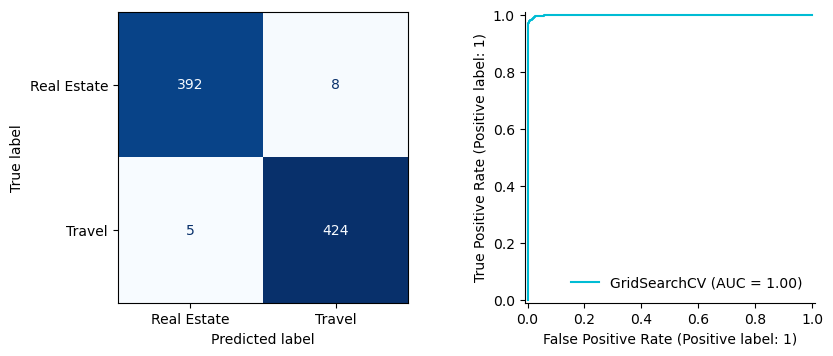

In [1094]:
metrics.append(evaluate_model(gs10,
                              X_train = X_train1,
                              X_test = X_test1,
                              y_train = y_train1,
                              y_test = y_test1
                             ))

---
**Model 11**

In [969]:
pipe11 = Pipeline([
    ('cvec3', CountVectorizer()),
    ('model11', LogisticRegression())
])

In [971]:
params11 = {
    'cvec3__stop_words': [None, 'english'],
    'cvec3__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'cvec3__min_df': [1, 3, 5],
    'cvec3__max_df': [.75, .85, .95],
    'cvec3__max_features': [None, 500, 1000, 5000],
    'model11__penalty': [None, 'l2'],
    'model11__random_state': [1029]
}

In [973]:
gs11 = GridSearchCV(
    pipe11,
    param_grid = params11,
    n_jobs = -1,
    verbose = 1
)

In [1096]:
gs11.fit(X_train1, y_train1)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(estimator=Pipeline(steps=[('cvec3', CountVectorizer()),
                                       ('model11', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec3__max_df': [0.75, 0.85, 0.95],
                         'cvec3__max_features': [None, 500, 1000, 5000],
                         'cvec3__min_df': [1, 3, 5],
                         'cvec3__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec3__stop_words': [None, 'english'],
                         'model11__penalty': [None, 'l2'],
                         'model11__random_state': [1029]},
             verbose=1)

In [1098]:
gs11.best_params_

{'cvec3__max_df': 0.75,
 'cvec3__max_features': 1000,
 'cvec3__min_df': 5,
 'cvec3__ngram_range': (1, 1),
 'cvec3__stop_words': None,
 'model11__penalty': 'l2',
 'model11__random_state': 1029}

In [1100]:
models.append(['gs11', 'LogReg and CountVectorizer'])

Training Score: 0.998
Best Accuracy Score: 0.983
Actual Accuracy Score: 0.983
Misclassification Rate: 0.017
Precision Score: 0.981
F1 Score: 0.984


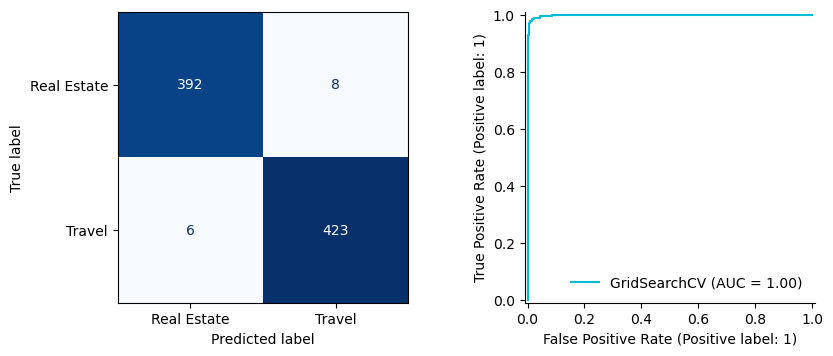

In [1102]:
metrics.append(evaluate_model(gs11,
                              X_train = X_train1,
                              X_test = X_test1,
                              y_train = y_train1,
                              y_test = y_test1
                             ))

----
**Model 12**

In [1104]:
pipe12 = Pipeline([
    ('cvec4', CountVectorizer()),
    ('model12', MultinomialNB()),
])

In [1106]:
params12 = {
    'cvec4__ngram_range': [(1, 2), (1, 3)],
    'cvec4__max_df': [*np.linspace(0.08, 0.1, 10)],
    'model12__alpha': [*np.linspace(0.47, 0.51, 10)]
}

In [1108]:
gs12 = GridSearchCV(
    pipe12,
    param_grid = params12,
    n_jobs = -1,
    verbose = 1
)

In [1110]:
gs12.fit(X_train1, y_train1)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(estimator=Pipeline(steps=[('cvec4', CountVectorizer()),
                                       ('model12', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec4__max_df': [0.08, 0.08222222222222222,
                                           0.08444444444444445,
                                           0.08666666666666667,
                                           0.08888888888888889,
                                           0.09111111111111111,
                                           0.09333333333333334,
                                           0.09555555555555556,
                                           0.09777777777777778, 0.1],
                         'cvec4__ngram_range': [(1, 2), (1, 3)],
                         'model12__alpha': [0.47, 0.47444444444444445,
                                            0.47888888888888886,
                                            0.48333333333333334,
                                            0.48777777777777775,
                                            0.4922222222222222,
                                            0.49666666666666665,
                                            0.5011111111111111,
                                            0.5055555555555555, 0.51]},
             verbose=1)

In [1112]:
gs12.best_params_

{'cvec4__max_df': 0.1, 'cvec4__ngram_range': (1, 2), 'model12__alpha': 0.47}

In [1122]:
models.append(['gs12', 'Naïve-Bayes and CountVectorizer'])

Training Score: 1.0
Best Accuracy Score: 0.988
Actual Accuracy Score: 0.987
Misclassification Rate: 0.013
Precision Score: 0.986
F1 Score: 0.987


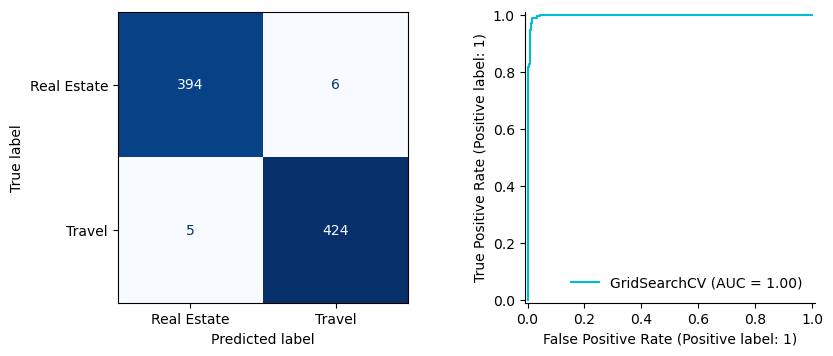

In [1124]:
metrics.append(evaluate_model(gs12,
                              X_train = X_train1,
                              X_test = X_test1,
                              y_train = y_train1,
                              y_test = y_test1
                             ))

---
**Metrics Summary**

In [1130]:
# build DF to serve as metrics summary table
summary = pd.DataFrame(models, columns = ['model_id', 'model_details'])
summary = pd.concat([summary, pd.DataFrame(metrics)], axis = 1)
summary

,model_id,model_details,train_accuracy,best_accuracy,test_accuracy,misclassification,precision,f1_score
0,gs1,LogReg and CountVectorizer,1.000,0.930,0.931,0.069,0.941,0.933
1,gs2,LogReg and TfidfVectorizer,1.000,0.938,0.935,0.065,0.958,0.936
2,gs3,KNClass and CountVectorizer,0.957,0.783,0.785,0.215,0.947,0.749
3,gs4,KNClass and TfidfVectorizer,1.000,0.904,0.912,0.088,0.936,0.913
4,gs5,RndmForest and TfidfVectorizer,0.947,0.866,0.865,0.135,0.818,0.879
5,gs6,RndmForest and TfidfVectorizer,0.976,0.873,0.859,0.141,0.820,0.872
6,gs7,LogReg and TfidfVectorizer,0.999,0.990,0.984,0.016,0.981,0.985
7,gs8,LogReg and TfidfVectorizer,0.999,0.990,0.984,0.016,0.981,0.985
8,gs9,LogReg and TfidfVectorizer,0.999,0.990,0.984,0.016,0.981,0.985
9,gs10,LogReg and TfidfVectorizer,0.999,0.990,0.984,0.016,0.981,0.985


The table above is a brief summary of key metrics for each one of the evaluated models.